In [111]:
import pandas as pd
import numpy as np
import requests
import re
import os
import json
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Gathering Data
- archive file

In [112]:
archive_df = pd.read_csv("twitter-archive-enhanced.csv")

In [113]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [114]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

- reading image prediction from url programtically

- image prediction file

In [115]:
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
r=requests.get(url)

- getting the file name from the url

In [116]:
file_name= url.split('/')[-1]
file_name

'image-predictions.tsv'

In [117]:
# making sure that the file doesnt exist in the same directory before creating it
if not os.path.isfile(file_name):
    with open(file_name , 'wb') as file:
        file.write(r.content)

In [118]:
prediction_df=pd.read_csv('image-predictions.tsv' , sep='\t')

In [119]:
prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [120]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


api file
- creating data frame using tweet-json.txt file with needed columns only!!1

In [121]:
df_list=[]
with open ('tweet-json.txt','r') as file:
    for line in file:
        tweet=json.loads(line)
        tweet_id=tweet['id']
        retweet_count=tweet['retweet_count']
        favorite_count=tweet['favorite_count']
        df_list.append({'tweet_id': tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': favorite_count})
api_df=pd.DataFrame(df_list)
api_df.head()

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256


In [122]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


# assessing Data
- archive_df

In [123]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [124]:
archive_df.name.sample(30)

102       Monkey
725        Penny
1048        Kilo
117     Clifford
1242        None
1727    Penelope
302         None
1054        Bell
2223        None
1509         Leo
976          Jax
369          one
1563      Lizzie
119        Dewey
464      Strudel
1157    Ashleigh
125         None
981         Finn
1055        Phil
790     Heinrich
923         None
1162    Reginald
146        Quinn
1890        None
139        Sammy
1462      Archie
1755         Tug
1906       Louis
647         None
630       Nimbus
Name: name, dtype: object

In [125]:
archive_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [126]:
archive_df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [127]:
archive_df[archive_df.name.str.islower()].name.value_counts()

a               55
the              8
an               7
very             5
one              4
quite            4
just             4
actually         2
not              2
getting          2
mad              2
this             1
life             1
officially       1
all              1
his              1
old              1
space            1
by               1
unacceptable     1
light            1
infuriating      1
such             1
my               1
incredibly       1
Name: name, dtype: int64

In [128]:
archive_df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [129]:
archive_df.tweet_id.duplicated().sum()

0

In [130]:
prediction_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [131]:
prediction_df.img_num.isnull().sum()


0

In [132]:
prediction_df.p1_dog.isnull().sum()

0

In [133]:
prediction_df.shape

(2075, 12)

In [134]:
archive_df.shape

(2356, 17)

In [135]:
api_df.shape

(2354, 3)

In [136]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [137]:
prediction_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [138]:
prediction_df.jpg_url.duplicated().sum()

66

In [139]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [140]:
api_df.isnull().sum()

favorite_count    0
retweet_count     0
tweet_id          0
dtype: int64

In [141]:
api_df.duplicated().sum()

0

# Quality and tidiness

### quality
- convert timestamp data type to date 
- replace 'a','an','the' and 'none' with null value
- delete 0 value from rating_dominator
- convert tweet_id to string archive_df
- convert tweet_id to string prediction_df
- convert tweet_id to string api_df
- remove duplicated 
- rename prediction_df.img_num to images_count
- delet no match rows between archive_df and prediction_df


### tidiness
- multi columns for dog stages, should be melted in one colum
- merge all data frame in one data fram and save into one file




# cleaning



In [142]:
# making copies of the data frames
clean_archive_df = archive_df.copy()
clean_prediction_df = prediction_df.copy()
clean_api_df = api_df.copy()

### incorrect data type

- timestamp column data type is not datetime

### Define

- changing timestamp data type to datetime

## code

In [143]:
# Convert timestamp to datetime data type
clean_archive_df['timestamp'] = pd.to_datetime(clean_archive_df['timestamp'])

# Test
clean_archive_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

### invalid Data

- removing recognized invalid names and replace with null

### code

In [144]:
# replace a,an,none and the with null
clean_archive_df.name.replace(('a', 'an', 'None','the'), (''), inplace=True)

In [145]:
# test
clean_archive_df.name.value_counts().sort_index()


                815
Abby              2
Ace               1
Acro              1
Adele             1
Aiden             1
Aja               1
Akumi             1
Al                1
Albert            2
Albus             2
Aldrick           1
Alejandro         1
Alexander         1
Alexanderson      1
Alf               1
Alfie             5
Alfy              1
Alice             2
Amber             1
Ambrose           1
Amy               1
Amélie            1
Anakin            2
Andru             1
Andy              1
Angel             1
Anna              1
Anthony           1
Antony            1
               ... 
Zeek              1
Zeke              3
Zeus              1
Ziva              1
Zoe               1
Zoey              3
Zooey             1
Zuzu              1
actually          2
all               1
by                1
getting           2
his               1
incredibly        1
infuriating       1
just              4
life              1
light             1
mad               2


### invalid data 

##### define

- rating_ numerator has 0 value, it will be removed

### code

In [146]:
# deleting 0 value from rating_dominator
clean_archive_df = clean_archive_df[clean_archive_df.rating_numerator != 0]

In [147]:
#test
clean_archive_df.loc[(clean_archive_df.rating_numerator <= 0)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Wrong data type

#### define

- tweet_id column is int data type and will be changed to string

### code

In [148]:
# convert tweet id to string clean_archive_df
clean_archive_df['tweet_id'] = clean_archive_df['tweet_id'].apply(str)

In [149]:
#test
clean_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2354 non-null object
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2354 non-null datetime64[ns]
source                        2354 non-null object
text                          2354 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2295 non-null object
rating_numerator              2354 non-null int64
rating_denominator            2354 non-null int64
name                          2354 non-null object
doggo                         2354 non-null object
floofer                       2354 non-null object
pupper                        2354 non-null object
puppo                         2354 non-null object
dtypes: datetime64[ns](

In [150]:
clean_archive_df.shape

(2354, 17)

In [151]:
clean_prediction_df.shape

(2075, 12)

# tidiness

### four coulmns should be be in one

### define

- will use melt function to convert all 4 columns into one (dog_stage)

### code

In [152]:
# making new coulmn named dog_stage
clean_archive_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [153]:
clean_archive_df = clean_archive_df.replace('None',np.nan)


In [154]:
clean_archive_df['doggo']+clean_archive_df['pupper']+clean_archive_df['puppo']+clean_archive_df['floofer']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
5       NaN
6       NaN
7       NaN
8       NaN
9       NaN
10      NaN
11      NaN
12      NaN
13      NaN
14      NaN
15      NaN
16      NaN
17      NaN
18      NaN
19      NaN
20      NaN
21      NaN
22      NaN
23      NaN
24      NaN
25      NaN
26      NaN
27      NaN
28      NaN
29      NaN
       ... 
2326    NaN
2327    NaN
2328    NaN
2329    NaN
2330    NaN
2331    NaN
2332    NaN
2333    NaN
2334    NaN
2335    NaN
2336    NaN
2337    NaN
2338    NaN
2339    NaN
2340    NaN
2341    NaN
2342    NaN
2343    NaN
2344    NaN
2345    NaN
2346    NaN
2347    NaN
2348    NaN
2349    NaN
2350    NaN
2351    NaN
2352    NaN
2353    NaN
2354    NaN
2355    NaN
Length: 2354, dtype: object

In [155]:
clean_archive_df.doggo.value_counts()

doggo    97
Name: doggo, dtype: int64

In [156]:
clean_archive_df.pupper.value_counts()

pupper    257
Name: pupper, dtype: int64

In [157]:
clean_archive_df.puppo.value_counts()

puppo    30
Name: puppo, dtype: int64

In [158]:
clean_archive_df.floofer.value_counts()

floofer    10
Name: floofer, dtype: int64

In [159]:
# testing 
clean_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN


In [160]:
#test
clean_archive_df.shape

(2354, 17)

In [161]:
clean_archive_df.tweet_id.duplicated().sum()

0

In [162]:
# removing dupicated rows
clean_archive_df = clean_archive_df.drop_duplicates()

In [163]:
# test
clean_archive_df.tweet_id.duplicated().sum()

0

In [164]:
clean_archive_df.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1407,699079609774645248,NaN,NaN,2016-02-15 03:55:41,"<a href=""http://twitter.com/download/iphone"" r...",Meet Reagan. He's a Persnicketus Derpson. Grea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/699079609...,8,10,Reagan,NaN,NaN,NaN,NaN


### image_prediction

### incorrect data type

### Define

- tweet_id will be changed from int to string

### code

In [165]:
# tweet id to string clean_prediction_df
clean_prediction_df.tweet_id = clean_prediction_df.tweet_id.apply(str)

In [166]:
# test
clean_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### changing column name

## define

- changing column img_num to more descriptive name image_counts

### code

In [167]:
# rename img_num to image_counts
clean_prediction_df = clean_prediction_df.rename(columns = {'img_num':'image_counts'})

In [168]:
#test
clean_prediction_df.columns

Index(['tweet_id', 'jpg_url', 'image_counts', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

### removing un matched columns before merging 

In [169]:
# check with archive file to find out if there is no matches
not_in = (~clean_prediction_df.tweet_id.isin(list(clean_archive_df.tweet_id)))

In [170]:
not_in.sum()

2

In [171]:
# clean no maches
clean_prediction_df = clean_prediction_df[~not_in]

In [172]:
#test
clean_prediction_df.shape

(2073, 12)

In [173]:
clean_prediction_df.sample(2)

,tweet_id,jpg_url,image_counts,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
221,670093938074779648,https://pbs.twimg.com/media/CUym4Y5WsAEiI9_.jpg,1,toy_poodle,0.383346,True,miniature_poodle,0.153678,True,chow,0.138543,True
678,683498322573824003,https://pbs.twimg.com/media/CXxGGOsUwAAr62n.jpg,1,Airedale,0.945362,True,Irish_terrier,0.026850,True,Lakeland_terrier,0.016826,True


# tidiness

#### merging archive and prediction data frames in one 

In [174]:
# merging archive and prediction in on data frame
archive_prediction_df = clean_archive_df.merge(clean_prediction_df, on =['tweet_id'], how = 'left')

In [175]:
#test
archive_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2353
Data columns (total 28 columns):
tweet_id                      2354 non-null object
in_reply_to_status_id         77 non-null float64
in_reply_to_user_id           77 non-null float64
timestamp                     2354 non-null datetime64[ns]
source                        2354 non-null object
text                          2354 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2295 non-null object
rating_numerator              2354 non-null int64
rating_denominator            2354 non-null int64
name                          2354 non-null object
doggo                         97 non-null object
floofer                       10 non-null object
pupper                        257 non-null object
puppo                         30 non-null object
jpg_url                       

### api_df

In [177]:
clean_api_df.head()

,favorite_count,retweet_count,tweet_id
0,39467,8853,892420643555336193
1,33819,6514,892177421306343426
2,25461,4328,891815181378084864
3,42908,8964,891689557279858688
4,41048,9774,891327558926688256


## incorrect data type

#### tweet_id will be converted to string 

### code

In [178]:
# convert tweet id to string clean_api_df
clean_api_df.tweet_id=clean_api_df['tweet_id'].apply(str)

In [179]:
# test
clean_api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
favorite_count    2354 non-null int64
retweet_count     2354 non-null int64
tweet_id          2354 non-null object
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


# tidiness

### merging all 3 files into one master file

#### code

In [180]:
# merging all data in just one data frame
twitter_archive_master = archive_prediction_df.merge(clean_api_df, on =['tweet_id'], how = 'left')
#test
twitter_archive_master.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,39467.0,8853.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,33819.0,6514.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,25461.0,4328.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,42908.0,8964.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,41048.0,9774.0


In [181]:
#twitter_archive_master.dog_stage.replace('',np.nan, inplace =True)


In [182]:
# sorting according to favorite_ count

twitter_archive_master.sort_values('favorite_count', inplace=True , ascending=False)
twitter_archive_master.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
412,822872901745569793,NaN,NaN,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/822872901...,...,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True,132810.0,48265.0
1037,744234799360020481,NaN,NaN,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744234799...,...,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,131075.0,79515.0
66,879415818425184262,NaN,NaN,2017-06-26 19:07:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Duddles. He did an attempt. 13/10 some...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/879415818...,...,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True,107956.0,45849.0
533,807106840509214720,NaN,NaN,2016-12-09 06:17:20,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/807106840...,...,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True,107015.0,56625.0
135,866450705531457537,NaN,NaN,2017-05-22 00:28:40,"<a href=""http://twitter.com/download/iphone"" r...",This is Jamesy. He gives a kiss to every other...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/866450705...,...,0.905334,True,Boston_bull,0.078060,True,pug,0.001771,True,106827.0,32883.0


In [183]:
# saving into new file
twitter_archive_master.to_csv("twitter_archive_master.csv")




# insights

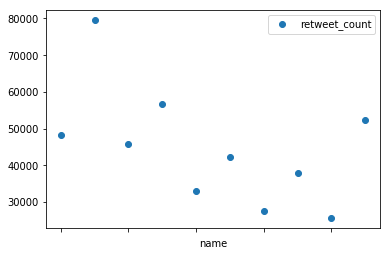

In [184]:
twitter_archive_master.head(10).plot(x='name', y='retweet_count', style='o');

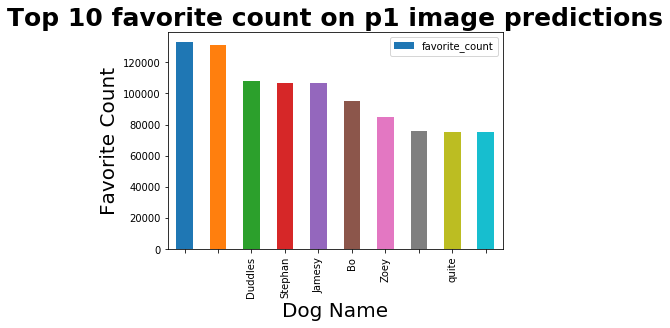

In [185]:
twitter_archive_master.head(10).plot.bar(x='name', y='favorite_count')

# Give title to chart
plt.title("Top 10 favorite count on p1 image predictions", fontweight="bold", fontsize = 25.0)

# X & Y text format
plt.xlabel('Dog Name', fontsize = 20.0)
plt.ylabel('Favorite Count', fontsize = 20.0)
plt.show()

In [186]:
dog_stage_df1 = twitter_archive_master.p1_dog.value_counts()

In [187]:
dog_stage_df2 = twitter_archive_master.p2_dog.value_counts()

In [188]:
dog_stage_df3 = twitter_archive_master.p3_dog.value_counts()

In [189]:
dog_stage_df = dog_stage_df1.append(dog_stage_df2)

In [190]:
dog_stage_df4 = dog_stage_df.append(dog_stage_df3).rename_axis('prediction_result').reset_index(name='count')

In [191]:
dog_stage_df4

,prediction_result,count
0,True,1532
1,False,541
2,True,1552
3,False,521
4,True,1498
5,False,575


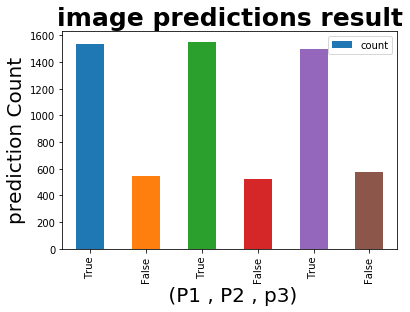

In [192]:
dog_stage_df4.head(6).plot.bar(x='prediction_result', y='count')
# Give title to chart
3
plt.title("image predictions result", fontweight="bold", fontsize = 25.0)
# X & Y text format
plt.xlabel(' (P1 , P2 , p3)', fontsize = 20.0)
plt.ylabel('prediction Count', fontsize = 20.0)
plt.show()


In [193]:
# getting the value count of each dog stage
dog_stage_doggo = twitter_archive_master.doggo.value_counts().rename_axis('stages').reset_index(name='counts')
dog_stage_pupper = twitter_archive_master.pupper.value_counts().rename_axis('stages').reset_index(name='counts')
dog_stage_puppo = twitter_archive_master.puppo.value_counts().rename_axis('stages').reset_index(name='counts')
dog_stage_floofer = twitter_archive_master.floofer.value_counts().rename_axis('stages').reset_index(name='counts')


In [194]:
# creating new data frame dog_stage 
df=dog_stage_doggo.append(dog_stage_pupper,ignore_index=True)

In [195]:
df1= df.append(dog_stage_puppo, ignore_index=True)

In [196]:
dog_stage= df1.append(dog_stage_floofer, ignore_index=True)

In [197]:
dog_stage

,stages,counts
0,doggo,97
1,pupper,257
2,puppo,30
3,floofer,10


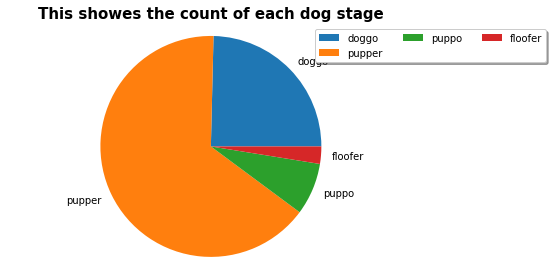

In [198]:
# Plot dataframe to pie chart
plt.pie(dog_stage['counts'],labels=dog_stage['stages'])

# View plot drop above
plt.axis('equal')

# Assign plot title
plt.title("This showes the count of each dog stage", fontweight="bold", fontsize=15.0)

# Legend layout
plt.legend(loc='upper left', bbox_to_anchor=(0.75, 1),ncol=3, fancybox=True, shadow=True)

# Display plot
plt.tight_layout()
plt.show()

